In [ ]:
%pip install -U \
  torch==2.0.1 \
  accelerate==0.24.1 \
  transformers==4.35.2 \
  torchvision==0.15.2 \
  diffusers==0.23.1 \
  xformers==0.0.21 \
  bitsandbytes==0.41.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55

# 데이터 세트

In [ ]:
local_dir = "./images_molly"

이미지 미리보기

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

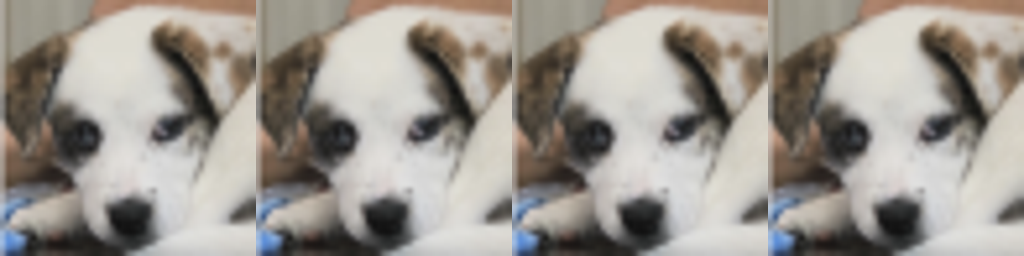

In [ ]:
import glob

#imgs = [Image.open(path) for path in glob.glob("./images_dreambooth/*.jpeg")]
imgs = [Image.open(path) for path in glob.glob("./images_molly/*.jpg")]
image_grid(imgs, 1, 4)

# 학습

In [ ]:
import argparse
import copy
import gc
import importlib
import itertools
import logging
import math
import os
import shutil
import warnings
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, model_info, upload_folder
from huggingface_hub.utils import insecure_hashlib
from packaging import version
from PIL import Image
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import compute_snr
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available

logger = get_logger(__name__)

In [ ]:
parser = argparse.ArgumentParser(description="Simple example of a training script.")
parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default="runwayml/stable-diffusion-v1-5",
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help=(
        "Revision of pretrained model identifier from huggingface.co/models. Trainable model components should be"
        " float32 precision."
    ),
)
parser.add_argument(
    "--tokenizer_name",
    type=str,
    default=None,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--instance_data_dir",
    type=str,
    default="images_molly",
    help="A folder containing the training data of instance images.",
)
parser.add_argument(
    "--class_data_dir",
    type=str,
    default=None,
    required=False,
    help="A folder containing the training data of class images.",
)
parser.add_argument(
    "--instance_prompt",
    type=str,
    default="a photo of molly dog",
    help="The prompt with identifier specifying the instance",
)
parser.add_argument(
    "--class_prompt",
    type=str,
    default=None,
    help="The prompt to specify images in the same class as provided instance images.",
)
parser.add_argument(
    "--with_prior_preservation",
    default=False,
    action="store_true",
    help="Flag to add prior preservation loss.",
)
parser.add_argument("--prior_loss_weight", type=float, default=1.0, help="The weight of prior preservation loss.")
parser.add_argument(
    "--num_class_images",
    type=int,
    default=200,
    help=(
        "Minimal class images for prior preservation loss. If there are not enough images already present in"
        " class_data_dir, additional images will be sampled with class_prompt."
    ),
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="dreambooth_model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=512,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--center_crop",
    default=False,
    action="store_true",
    help=(
        "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
        " cropped. The images will be resized to the resolution first before cropping."
    ),
)
parser.add_argument(
    "--train_text_encoder",
    action="store_true",
    help="Whether to train the text encoder. If set, the text encoder should be float32 precision.",
)
parser.add_argument(
    "--train_batch_size", type=int, default=4, help="Batch size (per device) for the training dataloader."
)
parser.add_argument(
    "--sample_batch_size", type=int, default=4, help="Batch size (per device) for sampling images."
)
parser.add_argument("--num_train_epochs", type=int, default=1)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=None,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=500,
    help=(
        "Save a checkpoint of the training state every X updates. Checkpoints can be used for resuming training via `--resume_from_checkpoint`. "
        "In the case that the checkpoint is better than the final trained model, the checkpoint can also be used for inference."
        "Using a checkpoint for inference requires separate loading of the original pipeline and the individual checkpointed model components."
        "See https://huggingface.co/docs/diffusers/main/en/training/dreambooth#performing-inference-using-a-saved-checkpoint for step by step"
        "instructions."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=(
        "Max number of checkpoints to store. Passed as `total_limit` to the `Accelerator` `ProjectConfiguration`."
        " See Accelerator::save_state https://huggingface.co/docs/accelerate/package_reference/accelerator#accelerate.Accelerator.save_state"
        " for more details"
    ),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=1,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=1e-4,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps",
    type=int,
    default=0,
    help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
parser.add_argument(
    "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
)
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
parser.add_argument(
    "--hub_model_id",
    type=str,
    default=None,
    help="The name of the repository to keep in sync with the local `output_dir`.",
)
parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    help="A prompt that is used during validation to verify that the model is learning.",
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images that should be generated during validation with `validation_prompt`.",
)
parser.add_argument(
    "--validation_steps",
    type=int,
    default=100,
    help=(
        "Run validation every X steps. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default=None,
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
        " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
    ),
)
parser.add_argument(
    "--prior_generation_precision",
    type=str,
    default=None,
    choices=["no", "fp32", "fp16", "bf16"],
    help=(
        "Choose prior generation precision between fp32, fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to  fp16 if a GPU is available else fp32."
    ),
)
parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
parser.add_argument(
    "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
)
parser.add_argument(
    "--set_grads_to_none",
    action="store_true",
    help=(
        "Save more memory by using setting grads to None instead of zero. Be aware, that this changes certain"
        " behaviors, so disable this argument if it causes any problems. More info:"
        " https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html"
    ),
)

parser.add_argument(
    "--offset_noise",
    action="store_true",
    default=False,
    help=(
        "Fine-tuning against a modified noise"
        " See: https://www.crosslabs.org//blog/diffusion-with-offset-noise for more information."
    ),
)
parser.add_argument(
    "--snr_gamma",
    type=float,
    default=None,
    help="SNR weighting gamma to be used if rebalancing the loss. Recommended value is 5.0. "
    "More details here: https://arxiv.org/abs/2303.09556.",
)
parser.add_argument(
    "--pre_compute_text_embeddings",
    action="store_true",
    help="Whether or not to pre-compute text embeddings. If text embeddings are pre-computed, the text encoder will not be kept in memory during training and will leave more GPU memory available for training the rest of the model. This is not compatible with `--train_text_encoder`.",
)
parser.add_argument(
    "--tokenizer_max_length",
    type=int,
    default=None,
    required=False,
    help="The maximum length of the tokenizer. If not set, will default to the tokenizer's max length.",
)
parser.add_argument(
    "--text_encoder_use_attention_mask",
    action="store_true",
    required=False,
    help="Whether to use attention mask for the text encoder",
)
parser.add_argument(
    "--skip_save_text_encoder", action="store_true", required=False, help="Set to not save text encoder"
)
parser.add_argument(
    "--validation_images",
    required=False,
    default=None,
    nargs="+",
    help="Optional set of images to use for validation. Used when the target pipeline takes an initial image as input such as when training image variation or superresolution.",
)
parser.add_argument(
    "--class_labels_conditioning",
    required=False,
    default=None,
    help="The optional `class_label` conditioning to pass to the unet, available values are `timesteps`.",
)
parser.add_argument(
    "--validation_scheduler",
    type=str,
    default="DPMSolverMultistepScheduler",
    choices=["DPMSolverMultistepScheduler", "DDPMScheduler"],
    help="Select which scheduler to use for validation. DDPMScheduler is recommended for DeepFloyd IF.",
)

args, _ = parser.parse_known_args()

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.with_prior_preservation:
    if args.class_data_dir is None:
        raise ValueError("You must specify a data directory for class images.")
    if args.class_prompt is None:
        raise ValueError("You must specify prompt for class images.")
else:
    # 로거가 아직 사용 가능하지 않습니다.
    if args.class_data_dir is not None:
        warnings.warn("You need not use --class_data_dir without --with_prior_preservation.")
    if args.class_prompt is not None:
        warnings.warn("You need not use --class_prompt without --with_prior_preservation.")

if args.train_text_encoder and args.pre_compute_text_embeddings:
    raise ValueError("`--train_text_encoder` cannot be used with `--pre_compute_text_embeddings`")

print(args)

Namespace(pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5', revision=None, tokenizer_name=None, instance_data_dir='images_molly', class_data_dir=None, instance_prompt='a photo of molly dog', class_prompt=None, with_prior_preservation=False, prior_loss_weight=1.0, num_class_images=200, output_dir='dreambooth_model', seed=None, resolution=512, center_crop=False, train_text_encoder=False, train_batch_size=4, sample_batch_size=4, num_train_epochs=1, max_train_steps=None, checkpointing_steps=500, checkpoints_total_limit=None, resume_from_checkpoint=None, gradient_accumulation_steps=1, gradient_checkpointing=False, learning_rate=0.0001, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, lr_power=1.0, use_8bit_adam=False, dataloader_num_workers=0, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, push_to_hub=False, hub_token=None, hub_model_id=None, logging_dir='logs', allow_tf32=False, report_to='tensorboa

In [ ]:
def log_validation(
    text_encoder,
    tokenizer,
    unet,
    vae,
    args,
    accelerator,
    weight_dtype,
    global_step,
    prompt_embeds,
    negative_prompt_embeds,
):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )

    pipeline_args = {}

    if vae is not None:
        pipeline_args["vae"] = vae

    if text_encoder is not None:
        text_encoder = accelerator.unwrap_model(text_encoder)

    # 파이프라인 생성 (참고: unet과 vae는 float32로 다시 적재됩니다)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        tokenizer=tokenizer,
        text_encoder=text_encoder,
        unet=accelerator.unwrap_model(unet),
        revision=args.revision,
        torch_dtype=weight_dtype,
        **pipeline_args,
    )

    # 간소화된 학습 목표를 기준으로 학습합니다. 이전에 분산을 예측하고 있었다면, 스케줄러가 이를 무시해야 합니다.
    scheduler_args = {}

    if "variance_type" in pipeline.scheduler.config:
        variance_type = pipeline.scheduler.config.variance_type

        if variance_type in ["learned", "learned_range"]:
            variance_type = "fixed_small"

        scheduler_args["variance_type"] = variance_type

    module = importlib.import_module("diffusers")
    scheduler_class = getattr(module, args.validation_scheduler)
    pipeline.scheduler = scheduler_class.from_config(pipeline.scheduler.config, **scheduler_args)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.pre_compute_text_embeddings:
        pipeline_args = {
            "prompt_embeds": prompt_embeds,
            "negative_prompt_embeds": negative_prompt_embeds,
        }
    else:
        pipeline_args = {"prompt": args.validation_prompt}

    # 추론 실행
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images = []
    if args.validation_images is None:
        for _ in range(args.num_validation_images):
            with torch.autocast("cuda"):
                image = pipeline(**pipeline_args, num_inference_steps=25, generator=generator).images[0]
            images.append(image)
    else:
        for image in args.validation_images:
            image = Image.open(image)
            image = pipeline(**pipeline_args, image=image, generator=generator).images[0]
            images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, global_step, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()

    return images


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    elif model_class == "T5EncoderModel":
        from transformers import T5EncoderModel

        return T5EncoderModel
    else:
        raise ValueError(f"{model_class} is not supported.")

In [ ]:
class DreamBoothDataset(Dataset):
    """
    모델을 미세 조정하기 위해 프롬프트와 함께 인스턴스 및 클래스 이미지가 준비된 데이터 세트.
    이 과정에서 이미지를 전처리하고 프롬프트를 토큰화합니다.
    """

    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        class_num=None,
        size=512,
        center_crop=False,
        encoder_hidden_states=None,
        class_prompt_encoder_hidden_states=None,
        tokenizer_max_length=None,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.encoder_hidden_states = encoder_hidden_states
        self.class_prompt_encoder_hidden_states = class_prompt_encoder_hidden_states
        self.tokenizer_max_length = tokenizer_max_length

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError(f"Instance {self.instance_data_root} images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            if class_num is not None:
                self.num_class_images = min(len(self.class_images_path), class_num)
            else:
                self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        instance_image = exif_transpose(instance_image)

        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)

        if self.encoder_hidden_states is not None:
            example["instance_prompt_ids"] = self.encoder_hidden_states
        else:
            text_inputs = tokenize_prompt(
                self.tokenizer, self.instance_prompt, tokenizer_max_length=self.tokenizer_max_length
            )
            example["instance_prompt_ids"] = text_inputs.input_ids
            example["instance_attention_mask"] = text_inputs.attention_mask

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            class_image = exif_transpose(class_image)

            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)

            if self.class_prompt_encoder_hidden_states is not None:
                example["class_prompt_ids"] = self.class_prompt_encoder_hidden_states
            else:
                class_text_inputs = tokenize_prompt(
                    self.tokenizer, self.class_prompt, tokenizer_max_length=self.tokenizer_max_length
                )
                example["class_prompt_ids"] = class_text_inputs.input_ids
                example["class_attention_mask"] = class_text_inputs.attention_mask

        return example


def collate_fn(examples, with_prior_preservation=False):
    has_attention_mask = "instance_attention_mask" in examples[0]

    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    if has_attention_mask:
        attention_mask = [example["instance_attention_mask"] for example in examples]

    # 사전 보존을 위해 클래스와 인스턴스 예시를 연결
    # 이렇게 하면 두 번의 순전파 전달을 피할 수 있습니다.
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

        if has_attention_mask:
            attention_mask += [example["class_attention_mask"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.cat(input_ids, dim=0)

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }

    if has_attention_mask:
        attention_mask = torch.cat(attention_mask, dim=0)
        batch["attention_mask"] = attention_mask

    return batch


class PromptDataset(Dataset):
    "여러 GPU에서 클래스 이미지를 생성하기 위해 프롬프트를 포함한 간단한 데이터 세트."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


def model_has_vae(args):
    config_file_name = os.path.join("vae", AutoencoderKL.config_name)
    if os.path.isdir(args.pretrained_model_name_or_path):
        config_file_name = os.path.join(args.pretrained_model_name_or_path, config_file_name)
        return os.path.isfile(config_file_name)
    else:
        files_in_repo = model_info(args.pretrained_model_name_or_path, revision=args.revision).siblings
        return any(file.rfilename == config_file_name for file in files_in_repo)


def tokenize_prompt(tokenizer, prompt, tokenizer_max_length=None):
    if tokenizer_max_length is not None:
        max_length = tokenizer_max_length
    else:
        max_length = tokenizer.model_max_length

    text_inputs = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

    return text_inputs


def encode_prompt(text_encoder, input_ids, attention_mask, text_encoder_use_attention_mask=None):
    text_input_ids = input_ids.to(text_encoder.device)

    if text_encoder_use_attention_mask:
        attention_mask = attention_mask.to(text_encoder.device)
    else:
        attention_mask = None

    prompt_embeds = text_encoder(
        text_input_ids,
        attention_mask=attention_mask,
    )
    prompt_embeds = prompt_embeds[0]

    return prompt_embeds

In [ ]:
logging_dir = Path(args.output_dir, args.logging_dir)

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

if args.report_to == "wandb":
    if not is_wandb_available():
        raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# 현재, accelerate.accumulate을 활용해 두 모델을 학습할 때는 그래디언트 누적이 불가능합니다.
# 이 기능은 곧 accelerate에서 활성화될 예정입니다. 현재는 두 모델을 학습할 때 그래디언트 누적을 허용하지 않습니다.
# 할 일 (patil-suraj): accelerate에서 두 모델을 활용한 그래디언트 누적이 가능해지면, 두 모델을 학습할 때 그래디언트 누적을 허용하지 않는 체크 사항을 제거하세요.
if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
    raise ValueError(
        "Gradient accumulation is not supported when training the text encoder in distributed training. "
        "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
    )

# 각 과정마다 디버깅을 위한 설정 로그를 남기기
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# 전달된 경우, 학습 시드를 설정
if args.seed is not None:
    set_seed(args.seed)

# 사전 보존이 활성화된 경우, 클래스 이미지를 생성
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < args.num_class_images:
        torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
        if args.prior_generation_precision == "fp32":
            torch_dtype = torch.float32
        elif args.prior_generation_precision == "fp16":
            torch_dtype = torch.float16
        elif args.prior_generation_precision == "bf16":
            torch_dtype = torch.bfloat16
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            torch_dtype=torch_dtype,
            safety_checker=None,
            revision=args.revision,
        )
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = args.num_class_images - cur_class_images
        logger.info(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

        sample_dataloader = accelerator.prepare(sample_dataloader)
        pipeline.to(accelerator.device)

        for example in tqdm(
            sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process
        ):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                hash_image = insecure_hashlib.sha1(image.tobytes()).hexdigest()
                image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                image.save(image_filename)

        del pipeline
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# 저장소 생성 처리
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# 토크나이저 적재
if args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, revision=args.revision, use_fast=False)
elif args.pretrained_model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
        use_fast=False,
    )


# 적절한 텍스트 인코더 클래스 적재
text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path, args.revision)

# 스케줄러와 모델 적재
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)

if model_has_vae(args):
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision
    )
else:
    vae = None

unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# `accelerator.save_state(...)`가 적절한 형식으로 직렬화되도록 사용자 지정 저장 및 로딩 훅 생성
def save_model_hook(models, weights, output_dir):
    if accelerator.is_main_process:
        for model in models:
            sub_dir = "unet" if isinstance(model, type(accelerator.unwrap_model(unet))) else "text_encoder"
            model.save_pretrained(os.path.join(output_dir, sub_dir))

            # 해당 모델이 다시 저장되지 않도록 가중치를 해제.
            weights.pop()

def load_model_hook(models, input_dir):
    while len(models) > 0:
        # 모델이 다시 적재되지 않도록 해제
        model = models.pop()

        if isinstance(model, type(accelerator.unwrap_model(text_encoder))):
            # 모델에 트랜스포머 스타일을 적재
            load_model = text_encoder_cls.from_pretrained(input_dir, subfolder="text_encoder")
            model.config = load_model.config
        else:
            # 모델에 디퓨저 스타일을 적재
            load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

        model.load_state_dict(load_model.state_dict())
        del load_model

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

if vae is not None:
    vae.requires_grad_(False)

if not args.train_text_encoder:
    text_encoder.requires_grad_(False)

if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder.gradient_checkpointing_enable()

# 모든 학습 가능한 모델이 완전 정밀도 상태인지 확인
low_precision_error_string = (
    "Please make sure to always have all model weights in full float32 precision when starting training - even if"
    " doing mixed precision training. copy of the weights should still be float32."
)

if accelerator.unwrap_model(unet).dtype != torch.float32:
    raise ValueError(
        f"Unet loaded as datatype {accelerator.unwrap_model(unet).dtype}. {low_precision_error_string}"
    )

if args.train_text_encoder and accelerator.unwrap_model(text_encoder).dtype != torch.float32:
    raise ValueError(
        f"Text encoder loaded as datatype {accelerator.unwrap_model(text_encoder).dtype}."
        f" {low_precision_error_string}"
    )

# Ampere GPU로 더 빠른 학습을 위해 TF32를 활성화,
# 자세한 내용은 https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices를 참조
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# 16GB GPU에서 메모리 사용량을 줄이거나 모델을 미세 조정하기 위해 8 비트 아담 옵티마이저 활용
메모리 사용량을 줄이거나 16GB GPU에서 모델을 미세 조정하기 위해 8-bit Adam을 사용하세요.

if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# 옵티마이저 생성
params_to_optimize = (
    itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

if args.pre_compute_text_embeddings:

    def compute_text_embeddings(prompt):
        with torch.no_grad():
            text_inputs = tokenize_prompt(tokenizer, prompt, tokenizer_max_length=args.tokenizer_max_length)
            prompt_embeds = encode_prompt(
                text_encoder,
                text_inputs.input_ids,
                text_inputs.attention_mask,
                text_encoder_use_attention_mask=args.text_encoder_use_attention_mask,
            )

        return prompt_embeds

    pre_computed_encoder_hidden_states = compute_text_embeddings(args.instance_prompt)
    validation_prompt_negative_prompt_embeds = compute_text_embeddings("")

    if args.validation_prompt is not None:
        validation_prompt_encoder_hidden_states = compute_text_embeddings(args.validation_prompt)
    else:
        validation_prompt_encoder_hidden_states = None

    if args.class_prompt is not None:
        pre_computed_class_prompt_encoder_hidden_states = compute_text_embeddings(args.class_prompt)
    else:
        pre_computed_class_prompt_encoder_hidden_states = None

    text_encoder = None
    tokenizer = None

    gc.collect()
    torch.cuda.empty_cache()
else:
    pre_computed_encoder_hidden_states = None
    validation_prompt_encoder_hidden_states = None
    validation_prompt_negative_prompt_embeds = None
    pre_computed_class_prompt_encoder_hidden_states = None

# 데이터 세트 및 데이터 로더 생성
train_dataset = DreamBoothDataset(
    instance_data_root=args.instance_data_dir,
    instance_prompt=args.instance_prompt,
    class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    class_prompt=args.class_prompt,
    class_num=args.num_class_images,
    tokenizer=tokenizer,
    size=args.resolution,
    center_crop=args.center_crop,
    encoder_hidden_states=pre_computed_encoder_hidden_states,
    class_prompt_encoder_hidden_states=pre_computed_class_prompt_encoder_hidden_states,
    tokenizer_max_length=args.tokenizer_max_length,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    collate_fn=lambda examples: collate_fn(examples, args.with_prior_preservation),
    num_workers=args.dataloader_num_workers,
)

# 스케줄러와 학습 단계 수에 대한 수학적 처리.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# `가속기`로 모든 것을 준비합니다.
if args.train_text_encoder:
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler
    )
else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

# 혼합 정밀도로 학습하기 위해 모든 고정되는 가중치(변형 자동 인코더(vae), 저순위 적응(lora)이 아닌 text_encoder와 저순위 적응(lora)이 아닌 U-Net)를 반 정밀도로 변환.
# 이러한 가중치는 추론에만 사용되므로, 완전 정밀도로 유지할 필요가 없습니다.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# 변형 자동 인코더와 U-Net을 장치(device)에 불러서 weight_dtype로 변환.
if vae is not None:
    vae.to(accelerator.device, dtype=weight_dtype)

if not args.train_text_encoder and text_encoder is not None:
    text_encoder.to(accelerator.device, dtype=weight_dtype)

# 학습 데이터 로더 크기가 변경됐을 수 있으므로 총 학습 단계를 다시 계산합니다.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# 학습 단계 계산 후에 학습 에포크(epoch) 수 다시 계산합니다.
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# 사용할 추적기를 초기화하고 설정 저장합니다.
# 추적기는 메인 프로세스에서 자동으로 초기화합니다.
if accelerator.is_main_process:
    tracker_config = vars(copy.deepcopy(args))
    tracker_config.pop("validation_images")
    accelerator.init_trackers("dreambooth", config=tracker_config)

# 학습 시작!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# 이전에 저장된 가중치와 상태 적재
if args.resume_from_checkpoint:
    if args.resume_from_checkpoint != "latest":
        path = os.path.basename(args.resume_from_checkpoint)
    else:
        # 최근 체크포인트 적재
        dirs = os.listdir(args.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        args.resume_from_checkpoint = None
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch
else:
    initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # 각 장치에 진행 표시줄을 한 번만 표시.
    disable=not accelerator.is_local_main_process,
)

for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    if args.train_text_encoder:
        text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=weight_dtype)

            if vae is not None:
                # 이미지를 잠재 공간으로 변환
                model_input = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                model_input = model_input * vae.config.scaling_factor
            else:
                model_input = pixel_values

            # 잠재 공간에 추가될 노이즈를 샘플링
            if args.offset_noise:
                noise = torch.randn_like(model_input) + 0.1 * torch.randn(
                    model_input.shape[0], model_input.shape[1], 1, 1, device=model_input.device
                )
            else:
                noise = torch.randn_like(model_input)
            bsz, channels, height, width = model_input.shape
            # 각 이미지마다 무작위로 타임스텝을 샘플링
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=model_input.device
            )
            timesteps = timesteps.long()

            # 각 타임스텝의 노이즈 크기에 따라 잠재 공간에 노이즈를 추가
            # (이것이 순방향 확산 과정)
            noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

            # 조건부 텍스트 임베딩 적재
            if args.pre_compute_text_embeddings:
                encoder_hidden_states = batch["input_ids"]
            else:
                encoder_hidden_states = encode_prompt(
                    text_encoder,
                    batch["input_ids"],
                    batch["attention_mask"],
                    text_encoder_use_attention_mask=args.text_encoder_use_attention_mask,
                )

            if accelerator.unwrap_model(unet).config.in_channels == channels * 2:
                noisy_model_input = torch.cat([noisy_model_input, noisy_model_input], dim=1)

            if args.class_labels_conditioning == "timesteps":
                class_labels = timesteps
            else:
                class_labels = None

            # 노이즈 잔여값을 예측
            model_pred = unet(
                noisy_model_input, timesteps, encoder_hidden_states, class_labels=class_labels
            ).sample

            if model_pred.shape[1] == 6:
                model_pred, _ = torch.chunk(model_pred, 2, dim=1)

            # 예측 유형에 따라 손실 목표를 설정
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(model_input, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            if args.with_prior_preservation:
                # 노이즈와 모델 예측값을 두 부분으로 나누어 각 부분에 대해 손실 계산
                model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                target, target_prior = torch.chunk(target, 2, dim=0)
                # 사전 손실 계산
                prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

            # 인스턴스 손실을 계산
            if args.snr_gamma is None:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            else:
                # https://arxiv.org/abs/2303.09556의 3.4절에 따라 손실 가중치를 계산합니다.
                # x_0 대신 노이즈를 예측하므로, 기존 공식이 약간 변경됩니다.
                # 이는 해당 논문의 4.2절에서 논의됩니다.
                snr = compute_snr(noise_scheduler, timesteps)
                base_weight = (
                    torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0] / snr
                )

                if noise_scheduler.config.prediction_type == "v_prediction":
                    # 속도 목표는 신호 대 잡음비(signal-to-noise ratio; SNR) 가중치가 1이 되도록 최소화해야 합니다.
                    mse_loss_weights = base_weight + 1
                else:
                    # 엡실론(Epsilon)과 샘플 모두 동일한 손실 가중치를 활용
                    mse_loss_weights = base_weight
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                loss = loss.mean()

            if args.with_prior_preservation:
                # 인스턴스 손실에 사전 손실을 합산
                loss = loss + args.prior_loss_weight * prior_loss

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    itertools.chain(unet.parameters(), text_encoder.parameters())
                    if args.train_text_encoder
                    else unet.parameters()
                )
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=args.set_grads_to_none)

        # 가속기가 뒤에서 최적화 단계를 수행했는지 확인
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # 상태를 저장하기 전에, 해당 저장 단계에서 `checkpoints_total_limit`을 초과하는지 확인
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # 새로운 체크포인트를 저장하기 전에, 체크포인트 수가 `checkpoints_total_limit - 1`개 이하이어야 한다.
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

                images = []

                if args.validation_prompt is not None and global_step % args.validation_steps == 0:
                    images = log_validation(
                        text_encoder,
                        tokenizer,
                        unet,
                        vae,
                        args,
                        accelerator,
                        weight_dtype,
                        global_step,
                        validation_prompt_encoder_hidden_states,
                        validation_prompt_negative_prompt_embeds,
                    )

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break

# 학습된 모듈로 파이프라인을 생성하고 저장.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    pipeline_args = {}

    if text_encoder is not None:
        pipeline_args["text_encoder"] = accelerator.unwrap_model(text_encoder)

    if args.skip_save_text_encoder:
        pipeline_args["text_encoder"] = None

    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        unet=accelerator.unwrap_model(unet),
        revision=args.revision,
        **pipeline_args,
    )

    # 간소화된 학습 목표를 기준으로 학습합니다. 이전에 분산을 예측하고 있었다면, 스케줄러가 이를 무시해야 합니다.
    scheduler_args = {}

    if "variance_type" in pipeline.scheduler.config:
        variance_type = pipeline.scheduler.config.variance_type

        if variance_type in ["learned", "learned_range"]:
            variance_type = "fixed_small"

        scheduler_args["variance_type"] = variance_type

    pipeline.scheduler = pipeline.scheduler.from_config(pipeline.scheduler.config, **scheduler_args)

    pipeline.save_pretrained(args.output_dir)

accelerator.end_training()

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'timestep_spacing', 'dynamic_thresholding_ratio', 'clip_sample_range', 'variance_type', 'sample_max_value', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'reverse_transformer_layers_per_block', 'encoder_hid_dim', 'addition_embed_type_num_heads', 'only_cross_attention', 'timestep_post_act', 'time_cond_proj_dim', 'num_attention_heads', 'resnet_time_scale_shift', 'mid_block_only_cross_attention', 'time_embedding_dim', 'dropout', 'addition_embed_type', 'resnet_skip_time_act', 'encoder_hid_dim_type', 'addition_time_embed_dim', 'time_embedding_type', 'conv_in_kernel', 'resnet_out_scale_factor', 'use_linear_projection', 'attention_type', 'projection_class_embeddings_input_di

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
{'timestep_spacing', 'prediction_type'} was not found in 

## 추론

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)

_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of dreambooth_model.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of dreambooth_model.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of dreambooth_model.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of dreambooth_model.
Loaded vae as AutoencoderKL from `vae` subfolder of dreambooth_model.
Loaded unet as UNet2DConditionModel from `unet` subfolder of dreambooth_model.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of dreambooth_model.


  0%|          | 0/25 [00:00<?, ?it/s]

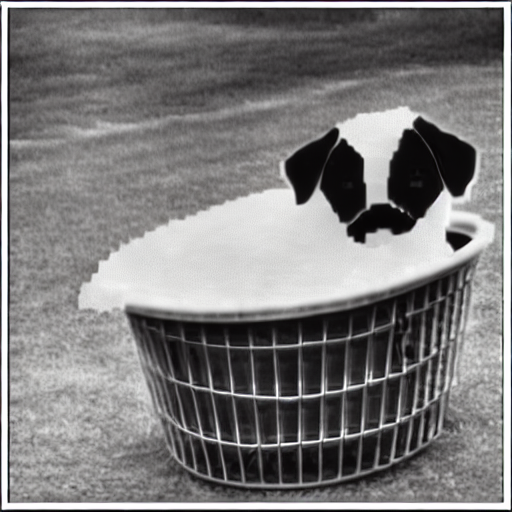

In [ ]:
prompt = "a 5k photo of Molly dog in a bucket"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image